![](img/330-banner.png)

# Lecture 17: Multi-class classification and introduction to computer vision 

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

## Learning objectives

- Apply classifiers to multi-class classification algorithms.
- Explain the role of neural networks in machine learning, and the pros/cons of using them.
- Explain why the methods we've learned previously would not be effective on image data.
- Apply pre-trained neural networks to classification and regression problems.
- Utilize pre-trained networks as feature extractors and combine them with models we've learned previously.

## ❓❓ Questions for you

### iClicker Exercise 19.1 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

- (A) It's possible to use word representations for text classification instead of bag-of-words representation. 
- (B) The topic model approach we used in the last lecture, Latent Dirichlet Allocation (LDA), is an unsupervised approach. 
- (C) In an LDA topic model, the same word can be associated with two different topics with high probability.
- (D) In an LDA topic model, a document is a mixture of multiple topics. 
- (E) If I train a topic model on a large collection of news articles with K = 10, I would get 10 topic labels (e.g., sports, culture, politics, finance) as output. 

## Multi-class, meta-strategies

- We have not explicitly talked about how models like logistic regression or SVM tackle multi-class classification.
- Can we use these classifiers when there are more than two classes? 
    - ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes 
- Can we use decision trees or KNNs for multi-class classification?
- What about decision trees or random forests? 

- Many linear classification models don't extend naturally to the multiclass case. 
- A common technique is to reduce multiclass classication into several instances of binary classification problems. 
- Two kind of "hacky" ways to reduce multi-class classification into binary classification:  
    - the one-vs.-rest approach
    - the one-vs.-one approach 

### One vs. Rest 

- 1v{2,3}, 2v{1,3}, 3v{1,2}
- Learn a binary model for each class which tries to separate that class from all of the other classes.
- If you have $k$ classes, it'll train $k$ binary classifiers, one for each class. 
- Trained on imbalanced datasets containing all examples.
- Given a test point, get scores from all binary classifiers (e.g., raw scores for logistic regression). 

- The classifier which has the highest score for this class "wins" and that's going to be the prediction for this class. 

- Since we have one binary classifier per class, for each class, we have coefficients per feature and an intercept. 

```{note}
Note that there is also a multinomial logistic regression also called as **the maxent classifier**. This is different than the above multi-class meta strategies. More on this in DSCI 573. 
```

Let's create some synthetic data with two features and three classes. 

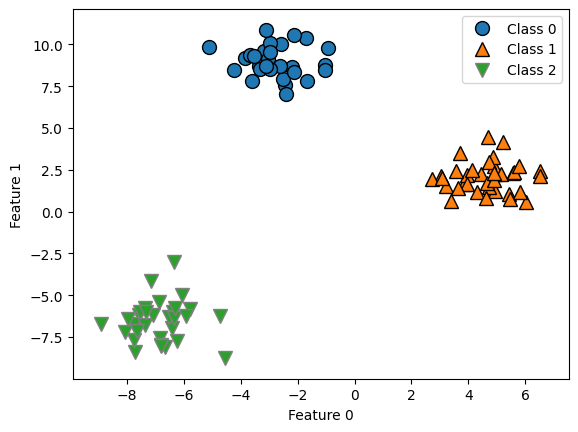

In [2]:
import mglearn
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=3, n_samples=120, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"]);

In [3]:
lr = LogisticRegression(max_iter=2000, multi_class="ovr")
lr.fit(X_train, y_train)
print("Coefficient shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


- This learns three binary linear models.
- So we have coefficients for two features for each of these three linear models. 
- Also we have three intercepts, one for each class. 

[Code credit](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#linear-models)

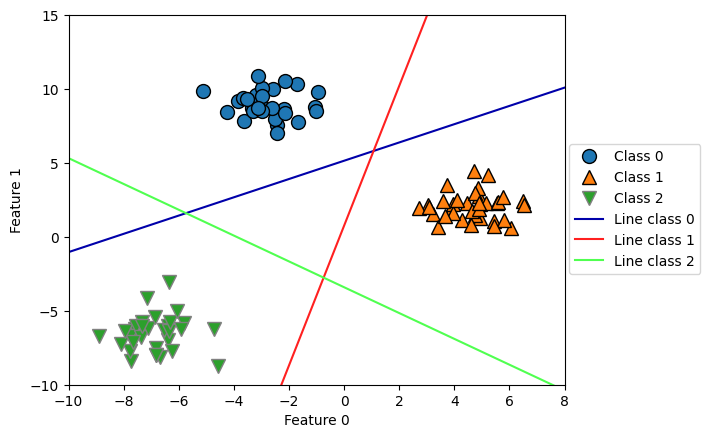

In [4]:
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(lr.coef_, lr.intercept_, mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(
    ["Class 0", "Class 1", "Class 2", "Line class 0", "Line class 1", "Line class 2"],
    loc=(1.01, 0.3),
);

In [5]:
def plot_test_points():
    test_points = [[-4.0, 12], [-2, 0.0], [-8, 3.0], [4, 8.5]]
    plt.plot(test_points[0][0], test_points[0][1], "k*", markersize=16)
    plt.plot(test_points[1][0], test_points[1][1], "k*", markersize=16)
    plt.plot(test_points[2][0], test_points[2][1], "k*", markersize=16)
    plt.plot(test_points[3][0], test_points[3][1], "k*", markersize=16)

- How would you classify the following points? 
    - Pick the class with the highest value for the classification formula. 

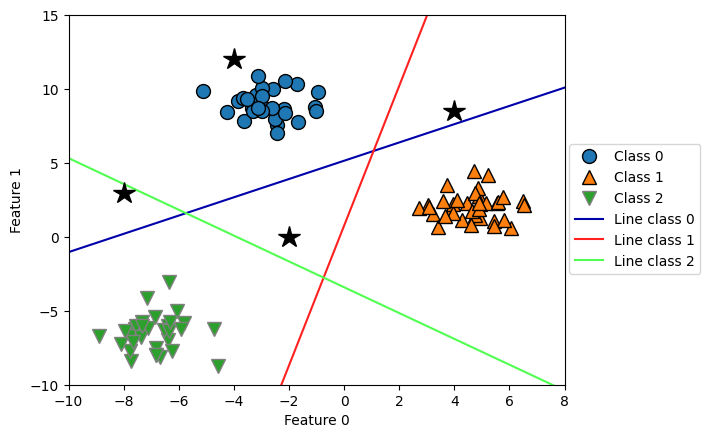

In [6]:
# You don't have to understand the code.
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(lr.coef_, lr.intercept_, mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plot_test_points()
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(
    ["Class 0", "Class 1", "Class 2", "Line class 0", "Line class 1", "Line class 2"],
    loc=(1.01, 0.3),
);

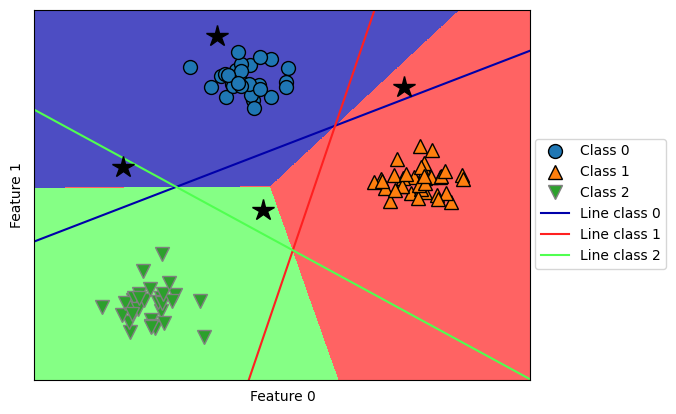

In [7]:
# You don't have to understand the code below.
mglearn.plots.plot_2d_classification(lr, X_train, fill=True, alpha=0.7)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(lr.coef_, lr.intercept_, mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plot_test_points()
plt.legend(
    ["Class 0", "Class 1", "Class 2", "Line class 0", "Line class 1", "Line class 2"],
    loc=(1.01, 0.3),
)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

### One Vs. One approach 

- Build a binary model for each pair of classes.
- 1v2, 1v3, 2v3
- Trains $\frac{n \times (n-1)}{2}$ binary classifiers
- Trained on relatively balanced subsets

### One Vs. One prediction

- Apply all of the classifiers on the test example.
- Count how often each class was predicted.  
- Predict the class with most votes. 

### Using OVR and OVO as wrappers

- You can use these strategies as meta-strategies for any binary classifiers. 
    - [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)
    - [`OneVsOneClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

- When do we use  `OneVsRestClassifier` and ``OneVsOneClassifier``
- It's not that likely for you to need `OneVsRestClassifier` or `OneVsOneClassifier` because most of the methods you'll use will have native multi-class support. 
- However, it's good to know in case you ever need to extend a binary classifier (perhaps one you've implemented on your own).

In [8]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

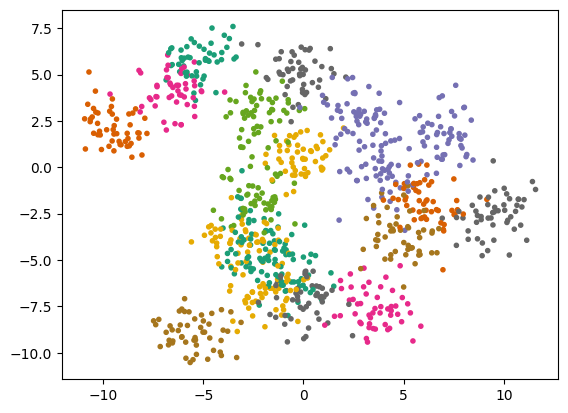

In [9]:
# Let's examine the time taken by OneVsRestClassifier and OneVsOneClassifier

# generate blobs with fixed random generator
X_multi, y_multi = make_blobs(n_samples=1000, centers=20, random_state=300)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi
)

plt.scatter(*X_multi.T, c=y_multi, marker=".", cmap="Dark2");

In [10]:
model = OneVsOneClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVO wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

144 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVO wrapper
0.788
0.784


In [11]:
model = OneVsRestClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVR wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

21.4 ms ± 58.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVR wrapper
0.7613333333333333
0.704


- As expected OVO takes more time compared to OVR.
- [Here](https://scikit-learn.org/stable/modules/multiclass.html) you will find summary of how `scikit-learn` handles multi-class classification for different classifiers. 

### True/False

1. One-vs.-one strategy uses all the available data when training each binary classifier.
2. For a 100-class classification problem, one-vs.-rest multi-class strategy will create 100 binary classifiers. 

### Multi-class classification on [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus

Let's examine precision, recall, and f1-score of different classes in the [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus.

In [12]:
df = pd.read_csv("data/cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)
sample_df.head()

wid reflection_period  \
hmid                            
27676   206               24h   
27678    45               24h   
27697   498               24h   
27705  5732               24h   
27715  2272               24h   

                                             original_hm  \
hmid                                                       
27676  We had a serious talk with some friends of our...   
27678                            I meditated last night.   
27697  My grandmother start to walk from the bed afte...   
27705  I picked my daughter up from the airport and w...   
27715        when i received flowers from my best friend   

                                                  moment  modified  \
hmid                                                                 
27676  We had a serious talk with some friends of our...      True   
27678                            I meditated last night.      True   
27697  My grandmother start to walk from the bed afte...      True   
27705  I picked my daughter up from the airport and w...      True   
27715        when i received flowers from my best friend      True   

       num_sentence     target predicted_category  
hmid                                               
27676             2    bonding            bonding  
27678             1    leisure            leisure  
27697             1  affection          affection  
27705             1    bonding          affection  
27715             1    bonding            bonding

In [13]:
sample_df["target"].value_counts()

affection           4810
achievement         4276
bonding             1750
enjoy_the_moment    1514
leisure             1306
nature               252
exercise             217
Name: target, dtype: int64

It's a multiclass classification problem! 

In [14]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train_happy, y_train_happy = train_df["moment"], train_df["target"]
X_test_happy, y_test_happy = test_df["moment"], test_df["target"]

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=2000)
)

In [16]:
pipe_lr.fit(X_train_happy, y_train_happy)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [17]:
preds = pipe_lr.predict(X_test_happy)[:5]
preds

array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'affection'], dtype=object)

Note that the output of `predict_proba` now contains a probability for each class:

In [18]:
pipe_lr.predict_proba(X_test_happy)[:5]

array([[7.06472052e-01, 3.74986128e-02, 5.65462917e-02, 4.48416413e-02,
        3.05695798e-02, 1.10293652e-01, 1.37781701e-02],
       [4.51114075e-03, 9.89340017e-01, 5.83647210e-04, 3.70764109e-03,
        2.90911954e-04, 6.37035298e-04, 9.29606282e-04],
       [2.13299806e-03, 1.51563900e-02, 9.78842547e-01, 1.36505803e-03,
        1.26043211e-03, 9.41950992e-04, 3.00623850e-04],
       [1.13093076e-01, 9.17955207e-02, 2.38830895e-02, 5.06663395e-01,
        7.31006756e-03, 2.49573518e-01, 7.68133370e-03],
       [7.72068583e-02, 5.53170569e-01, 3.87164814e-02, 8.14773196e-02,
        2.38206320e-02, 2.08447745e-01, 1.71603946e-02]])

And you'll see that each row adds up to 1, as expected:

In [19]:
pipe_lr.predict_proba(X_test_happy).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

We can also make a confusion matrix:

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


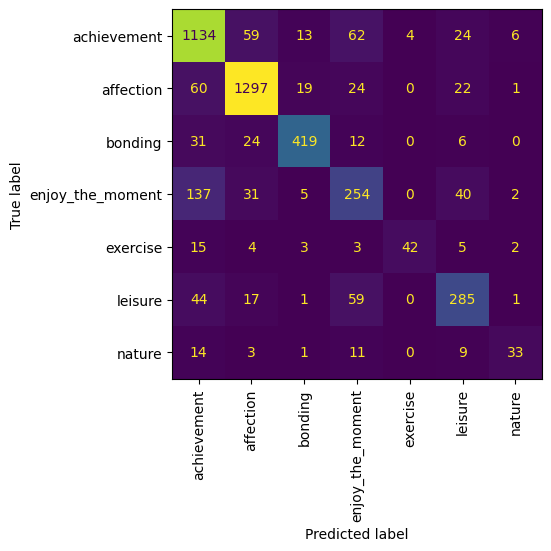

In [20]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(
    pipe_lr,
    X_test_happy,
    y_test_happy,
    values_format="d",
    xticks_rotation="vertical",
    colorbar=False,
);

And print the classification report. 

In [21]:
print(classification_report(y_test_happy, pipe_lr.predict(X_test_happy)))

                  precision    recall  f1-score   support

     achievement       0.79      0.87      0.83      1302
       affection       0.90      0.91      0.91      1423
         bonding       0.91      0.85      0.88       492
enjoy_the_moment       0.60      0.54      0.57       469
        exercise       0.91      0.57      0.70        74
         leisure       0.73      0.70      0.71       407
          nature       0.73      0.46      0.57        71

        accuracy                           0.82      4238
       macro avg       0.80      0.70      0.74      4238
    weighted avg       0.82      0.82      0.81      4238



- Seems like there is a lot of variation in the scores for different classes. 
- The model is performing pretty well on _affection_ class but not that well on _enjoy_the_moment_ and _nature_ classes.  

How are the predictions made? 

In [22]:
pipe_lr.predict_proba(X_test_happy)[:5]

array([[7.06472052e-01, 3.74986128e-02, 5.65462917e-02, 4.48416413e-02,
        3.05695798e-02, 1.10293652e-01, 1.37781701e-02],
       [4.51114075e-03, 9.89340017e-01, 5.83647210e-04, 3.70764109e-03,
        2.90911954e-04, 6.37035298e-04, 9.29606282e-04],
       [2.13299806e-03, 1.51563900e-02, 9.78842547e-01, 1.36505803e-03,
        1.26043211e-03, 9.41950992e-04, 3.00623850e-04],
       [1.13093076e-01, 9.17955207e-02, 2.38830895e-02, 5.06663395e-01,
        7.31006756e-03, 2.49573518e-01, 7.68133370e-03],
       [7.72068583e-02, 5.53170569e-01, 3.87164814e-02, 8.14773196e-02,
        2.38206320e-02, 2.08447745e-01, 1.71603946e-02]])

In [23]:
np.argmax(pipe_lr.predict_proba(X_test_happy), axis=1)

array([0, 1, 2, ..., 1, 0, 2])

In [24]:
classes = pipe_lr.classes_
classes

array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'exercise', 'leisure', 'nature'], dtype=object)

In [25]:
y_hat = pipe_lr.predict(X_test_happy)
y_hat

array(['achievement', 'affection', 'bonding', ..., 'affection',
       'achievement', 'bonding'], dtype=object)

How many coefficients have we learned? 

In [26]:
pipe_lr.named_steps["logisticregression"].coef_.shape

(7, 8060)

- We have one coefficient per feature _per class_. 
- Let's examine them. 

In [27]:
feature_names = pipe_lr.named_steps["countvectorizer"].get_feature_names()
lr_coefs = pd.DataFrame(
    data=pipe_lr.named_steps["logisticregression"].coef_.T,
    index=feature_names,
    columns=classes,
).sort_values("bonding", ascending=False)
lr_coefs

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


achievement  affection   bonding  enjoy_the_moment  exercise  \
friend       -1.687529  -0.183608  5.589866         -1.707829  0.330456   
friends      -1.304287   0.052779  5.246125         -1.992716  0.328815   
roommate     -1.327202  -0.690686  3.418085         -1.138203 -0.078646   
coworkers    -0.588496  -0.606175  3.011513         -1.098932 -0.088536   
coworker     -0.934857  -0.591312  2.770930         -0.560366 -0.093246   
...                ...        ...       ...               ...       ...   
feelings      0.057296   1.194994 -0.898329         -0.123828 -0.103999   
jogging      -0.046343  -0.319887 -0.909238         -0.098763  1.521341   
telling      -0.436909   0.870929 -1.070986          0.694175 -0.066820   
drive        -0.150838   0.584506 -1.184986          0.891987 -0.239585   
boy           1.398748   0.288127 -1.327434          0.138895 -0.261471   

            leisure    nature  
friend    -1.769253 -0.572105  
friends   -1.559656 -0.771061  
roommate  -0.070284 -0.113063  
coworkers -0.518752 -0.110623  
coworker  -0.415496 -0.175652  
...             ...       ...  
feelings  -0.093033 -0.033103  
jogging   -0.130390 -0.016719  
telling    0.038809 -0.029197  
drive     -0.453318  0.552235  
boy       -0.162182 -0.074683  

[8060 rows x 7 columns]

The interpretation is a feature importance for predicting a certain class. For example:

In [28]:
lr_coefs.loc["friend"][2]

5.589866402474926

- This means that if the value for the feature "friend" is bigger, you are more likely to predict class "bonding". 

- If you want a general feature importance irrespective of class, you could try looking at the sum of the squares of the coefficients, which is what sklearn does:

In [29]:
(lr_coefs ** 2).sum(axis=1).sort_values(ascending=False)

friend       4.061151e+01
friends      3.633188e+01
husband      2.764409e+01
wife         2.542235e+01
son          2.361098e+01
                 ...     
curiosity    1.996160e-11
gang         1.728724e-11
teases       1.728724e-11
horror       1.728724e-11
cinemas      1.728724e-11
Length: 8060, dtype: float64

In [30]:
# ?LogisticRegression

- We can see that there's a `multi_class` parameter, that can be set to `'ovr'` or `'multinomial'`, or you can have it automatically choose between the two, which is the default.
  - In CPSC 340 we discuss in detail the difference between these two approaches.
  - In CPSC 340 we make an argument for preferring `'multinomial'`, but in short it doesn't matter which one you choose.

## Break (5 min)

![](img/eva-coffee.png)

## Intro to computer vision

- [Computer vision](https://en.wikipedia.org/wiki/Computer_vision) refers to understanding images/videos, usually using ML/AI. 
- Computer vision has many tasks of interest:
  - image classification: is this a cat or a dog?
  - object localization: where are the people in this image?
  - image segmentation: what are the various parts of this image?
  - motion detection: what moved between frames of a video?
  - and much more...
- We will focus on image classification.

## Intro to neural networks

- Very popular these days under the name **deep learning**. 
- Neural networks apply a sequence of transformations on your input data.
- At a very high level you can think of them as `Pipelines` in `sklearn`. 
- A neural network is a model that's sort of like its own pipeline
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.

![](img/pipeline.png)

<!-- <img src='./img/pipeline.png' width="800"> -->
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

- They can be viewed a generalization of linear models where we apply a series of transformations. 
- Here is graphical representation of logistic regression model. 
    - We have 4 features: x[0], x[1], x[2], x[3]

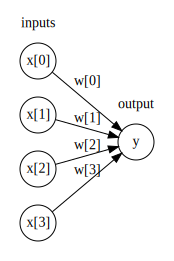

In [31]:
import mglearn

display(mglearn.plots.plot_logistic_regression_graph())

- Below we are adding one "layer" of transformations in between features and the target. 
- We are repeating the the process of computing the weighted sum multiple times.  
- The **hidden units** (e.g., h[1], h[2], ...) represent the intermediate processing steps. 

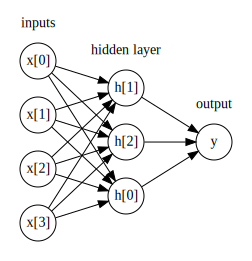

In [32]:
display(mglearn.plots.plot_single_hidden_layer_graph())

- Now we are adding one more layer of transformations. 

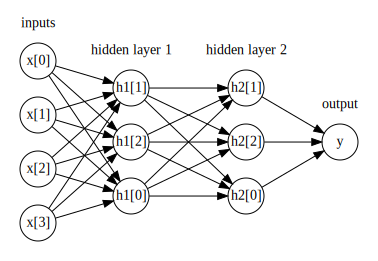

In [33]:
display(mglearn.plots.plot_two_hidden_layer_graph())

- Important question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 4 to 3 to 3 to 1.

- To make them really powerful compared to the linear models, we apply a non-linear function to the weighted sum for each hidden node. 

### Terminology

- Neural network = neural net
- Deep learning ~ using neural networks

### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit. 

### Why neural networks?

- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.  

### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable.

### Why not neural networks?

- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them on your own without further training
  - Take CPSC 340 and other courses if you're interested.
  - I'll show you some ways to use neural networks without calling `fit`.

### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.

- The current big players are:

1. [TensorFlow](https://www.tensorflow.org)
2. [PyTorch](http://pytorch.org)

- Both are heavily used in industry.
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## Working with images

### Dataset

In [34]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
IMAGE_SIZE = 200

data_transforms_bw = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                        
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
        ]
    ),
}
data_dir = "data/animal-faces"
image_datasets_bw = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_bw[x])
    for x in ["train", "valid"]
}
dataloaders_bw = {
    x: torch.utils.data.DataLoader(
        image_datasets_bw[x], batch_size=24, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets_bw[x]) for x in ["train", "valid"]}
class_names = image_datasets_bw["train"].classes

In [35]:
# Get a batch of training data
inputs_bw, classes = next(iter(dataloaders_bw["train"]))

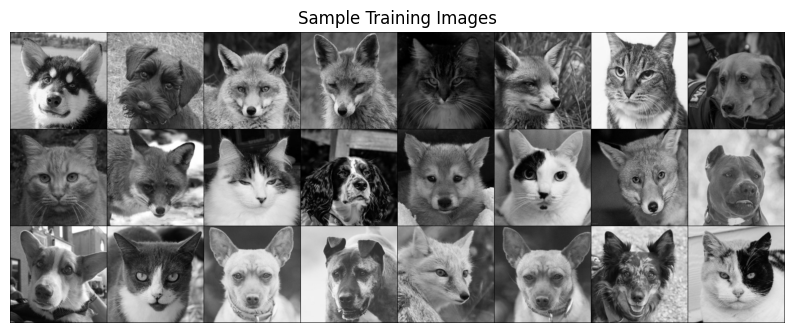

In [36]:
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(inputs_bw, padding=1, normalize=True),(1, 2, 0)));

In [37]:
print(f"Classes: {image_datasets_bw['train'].classes}")
print(f"Class count: {image_datasets_bw['train'].targets.count(0)}, {image_datasets_bw['train'].targets.count(1)}, {image_datasets_bw['train'].targets.count(2)}")
print(f"Samples:", len(image_datasets_bw["train"]))
print(f"First sample: {image_datasets_bw['train'].samples[0]}")

Classes: ['cat', 'dog', 'wild']
Class count: 50, 50, 50
Samples: 150
First sample: ('data/animal-faces/train/cat/flickr_cat_000002.jpg', 0)


### Logistic regression with flatten representation of images

- How can we train traditional ML models designed for tabular data on this data?
- Let's flatten the images and trained Logistic regression. 

In [38]:
flatten_transforms = transforms.Compose([
                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                    transforms.Grayscale(num_output_channels=1),
                    transforms.ToTensor(),
                    transforms.Lambda(torch.flatten)])
train_flatten = torchvision.datasets.ImageFolder(root='./data/animal-faces/train', transform=flatten_transforms)
valid_flatten = torchvision.datasets.ImageFolder(root='./data/animal-faces/valid', transform=flatten_transforms)                                                

In [39]:
train_dataloader = torch.utils.data.DataLoader(train_flatten, batch_size=150, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_flatten, batch_size=150, shuffle=True)

In [40]:
flatten_train, y_train = next(iter(train_dataloader))
flatten_valid, y_valid = next(iter(valid_dataloader))

In [41]:
flatten_train.shape

torch.Size([150, 40000])

In [42]:
lr_flatten_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=3000))
lr_flatten_pipe.fit(flatten_train.numpy(), y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [43]:
lr_flatten_pipe.score(flatten_train.numpy(), y_train)

1.0

In [44]:
lr_flatten_pipe.score(flatten_valid.numpy(), y_valid)

0.6666666666666666

We are getting not so great validation results :(.                                      

- Why flattening images is a bad idea?
  - By "flattening" the image we throw away useful information.

This is what we see. 

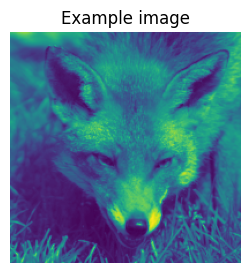

In [45]:
plt.figure(figsize=(3, 3)); plt.axis("off"); plt.title("Example image")
plt.imshow(flatten_train[4].reshape(200,200));

- This is what the computer sees:

In [46]:
flatten_train[4].numpy()

array([0.64705884, 0.64705884, 0.654902  , ..., 0.32156864, 0.4392157 ,
       0.40784314], dtype=float32)

- Hard to classify this!
- [Convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) can take in images without flattening them. 
  - We won't cover CNNs here, but they are in CPSC 340.

<br><br>

## Transfer learning

- In practice, very few people train an entire CNN from scratch because it requires a large dataset, powerful computers, and a huge amount of human effort to train the model. 
- Instead, a common practice is to download a pre-trained model and fine tune it for your task.   
- This is called **transfer learning**. 
- Transfer learning is one of the most common techniques used in the context of computer vision and natural language processing.
    - In the last lecture we used pre-trained embeddings to train create text representation.     

- There are many deep learning architectures out there that have been very successful across a wide range of problem, e.g.: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these are trained on famous datasets such as ImageNet (which contains 1.2 million labelled images with 1000 categories)
- The idea of transfer learning is that instead of developing a machine learning model from scratch, you use these available pre-trained models for your tasks either directly or by fine tuning them. 

### ImageNet

- [ImageNet](http://www.image-net.org/) is an image dataset that became a very popular benchmark in the field ~10 years ago. 
    - There are 14 million images and 1000 classes.
    - Here are some example classes. 
    - [Wikipedia article](https://en.wikipedia.org/wiki/ImageNet) on ImageNet


In [47]:
with open("data/imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
classes[100:110]

['black swan, Cygnus atratus',
 'tusker',
 'echidna, spiny anteater, anteater',
 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 'wallaby, brush kangaroo',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'wombat',
 'jellyfish',
 'sea anemone, anemone',
 'brain coral']

<br><br>

### Using pre-trained models out-of-the-box 

- Remember this example I showed you in the intro video (our very first lecture)?
- We used a pre-trained model vgg16 which is trained on the ImageNet data. 
- We preprocess the given image. 
- We get prediction from this pre-trained model on a given image along with prediction probabilities.  
- It's going to spit of one of the 1000 classes from ImageNet. 

In [48]:
def classify_image(img, topn = 4):
    clf = vgg16(weights='VGG16_Weights.DEFAULT')
    preprocess = transforms.Compose([
                 transforms.Resize(299),
                 transforms.CenterCrop(299),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225]),])

    with open('data/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]
    
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    clf.eval()
    output = clf(batch_t)
    _, indices = torch.sort(output, descending=True)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    d = {'Class': [classes[idx] for idx in indices[0][:topn]], 
         'Probability score': [np.round(probabilities[0, idx].item(),3) for idx in indices[0][:topn]]}
    df = pd.DataFrame(d, columns = ['Class','Probability score'])
    return df

In [49]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16

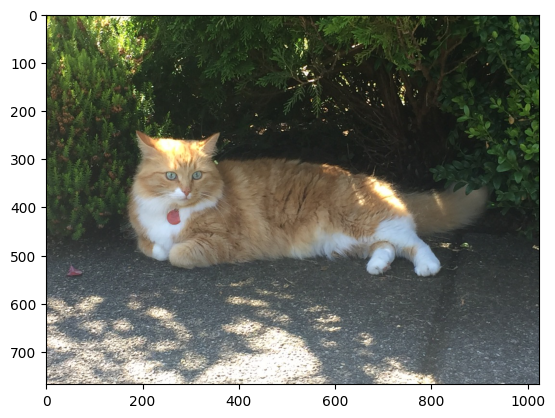

                         Class  Probability score
                     tiger cat              0.357
              tabby, tabby cat              0.207
               lynx, catamount              0.049
Pembroke, Pembroke Welsh corgi              0.046
--------------------------------------------------------------


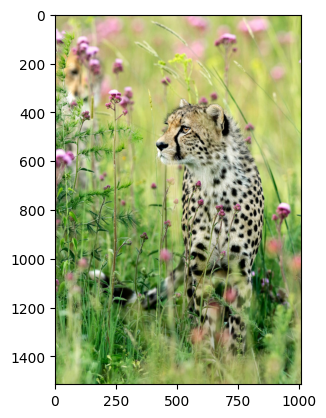

                                     Class  Probability score
         cheetah, chetah, Acinonyx jubatus              0.982
                  leopard, Panthera pardus              0.012
jaguar, panther, Panthera onca, Felis onca              0.004
       snow leopard, ounce, Panthera uncia              0.001
--------------------------------------------------------------


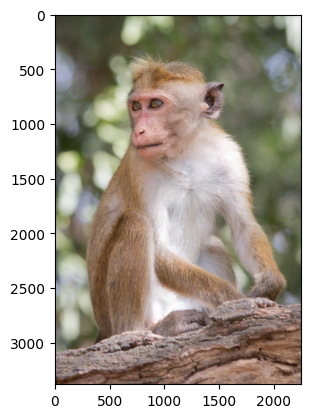

                                   Class  Probability score
                                 macaque              0.714
patas, hussar monkey, Erythrocebus patas              0.122
      proboscis monkey, Nasalis larvatus              0.098
                   guenon, guenon monkey              0.017
--------------------------------------------------------------


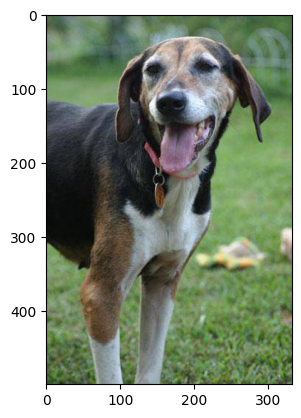

                        Class  Probability score
Walker hound, Walker foxhound              0.577
                  EntleBucher              0.089
             English foxhound              0.086
                       beagle              0.063
--------------------------------------------------------------


In [50]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("data/test_images/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- We got these predictions without "doing the ML ourselves".
- We are using **pre-trained** `vgg16` model which is available in `torchvision`
- `torchvision` has many such pre-trained models available that have been very successful across a wide range of tasks: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these models have been pre-trained on famous datasets like **ImageNet**. 

Let's see what labels this pre-trained model give us for some images which are very different from the training set. 

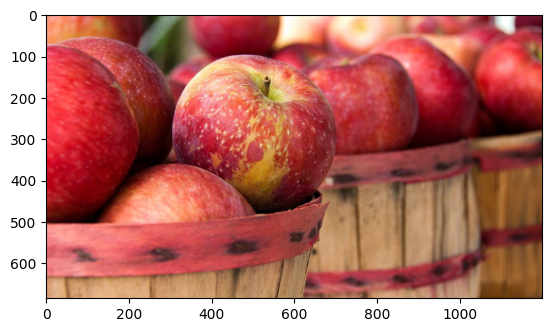

                                      Class  Probability score
                                        fig              0.657
                                pomegranate              0.181
grocery store, grocery, food market, market              0.040
                                      crate              0.022
--------------------------------------------------------------


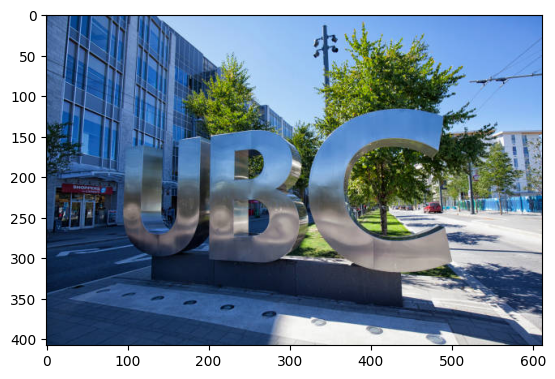

                                               Class  Probability score
                                         toilet seat              0.171
                                          safety pin              0.060
bannister, banister, balustrade, balusters, handrail              0.039
                                              bubble              0.035
--------------------------------------------------------------


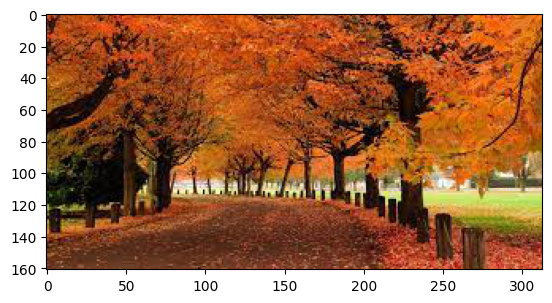

                                                    Class  Probability score
worm fence, snake fence, snake-rail fence, Virginia fence              0.135
                                             valley, vale              0.044
                                                     barn              0.036
                                                   castle              0.028
--------------------------------------------------------------


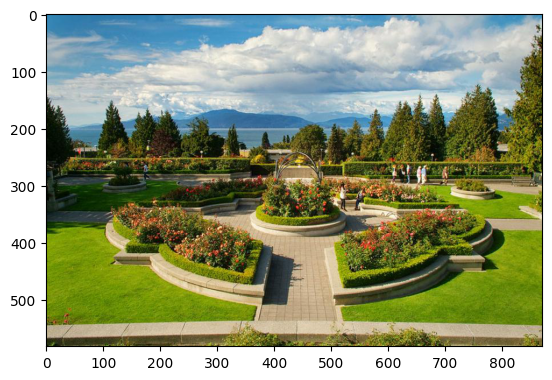

              Class  Probability score
     patio, terrace              0.196
           fountain              0.173
lakeside, lakeshore              0.097
            sundial              0.087
--------------------------------------------------------------


In [51]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("data/UBC_img/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- It's not doing very well here because ImageNet don't have proper classes for these images. 
- Here we are using pre-trained models out-of-the-box. 
- Can we use pre-trained models for our own classification problem with our classes? 
- Yes!! 

## Using pre-trained models as feature extractor

- Here we will use pre-trained models to extract features.
- We will pass our specific data through a pre-trained network to get a feature vector for each example in the data. 
- You train a machine learning classifier such as logistic regression or random forest using these extracted feature vectors. 

In [52]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import os

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cpu


### Reading the data

- You are not expected to understand this code. 

In [54]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ]
    ),
    "valid": transforms.Compose(
        [
            # transforms.Resize(256),
            # transforms.CenterCrop(224),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                        
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),                        
        ]
    ),
}
data_dir = "data/animal-faces"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

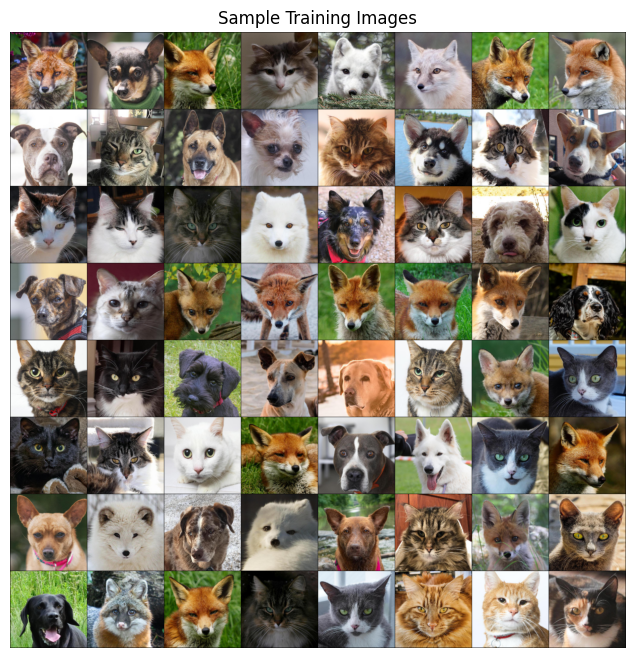

In [56]:
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [57]:
print(f"Classes: {image_datasets['train'].classes}")
print(f"Class count: {image_datasets['train'].targets.count(0)}, {image_datasets['train'].targets.count(1)}, {image_datasets['train'].targets.count(2)}")
print(f"Samples:", len(image_datasets["train"]))
print(f"First sample: {image_datasets['train'].samples[0]}")

Classes: ['cat', 'dog', 'wild']
Class count: 50, 50, 50
Samples: 150
First sample: ('data/animal-faces/train/cat/flickr_cat_000002.jpg', 0)


In [58]:
def get_features(model, train_loader, valid_loader):
    """Extract output of squeezenet model"""
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_valid = torch.empty((0, 1024))
        y_valid = torch.empty((0))
        for X, y in train_loader:
            Z_train = torch.cat((Z_train, model(X)), dim=0)
            y_train = torch.cat((y_train, y))
        for X, y in valid_loader:
            Z_valid = torch.cat((Z_valid, model(X)), dim=0)
            y_valid = torch.cat((y_valid, y))
    return Z_train.detach(), y_train.detach(), Z_valid.detach(), y_valid.detach()

In [59]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = nn.Identity()  # remove that last "classification" layer

In [60]:
Z_train, y_train, Z_valid, y_valid = get_features(
    densenet, dataloaders["train"], dataloaders["valid"]
)

Now we have some extracted features. 

In [61]:
Z_train.shape

torch.Size([150, 1024])

In [62]:
import pandas as pd
pd.DataFrame(Z_train).head()

0         1         2         3         4         5         6     \
0  0.000269  0.003606  0.001462  0.001768  0.091972  1.006288  0.000926   
1  0.000449  0.011098  0.000600  0.001110  0.217502  0.618601  0.000214   
2  0.000259  0.003335  0.003775  0.002137  0.162129  1.133260  0.000546   
3  0.000212  0.003788  0.003411  0.001745  0.068040  0.347854  0.000717   
4  0.000103  0.001574  0.001285  0.002992  0.052868  1.136636  0.001481   

       7         8         9     ...      1014      1015      1016      1017  \
0  0.002996  0.294866  0.000364  ...  1.092252  0.477308  2.836322  0.456931   
1  0.005907  0.343445  0.000174  ...  0.967964  1.411620  0.500827  0.000000   
2  0.003358  0.247900  0.000193  ...  0.296275  0.395652  0.721121  0.819996   
3  0.004914  0.169182  0.000217  ...  0.855812  1.426616  0.205596  1.471434   
4  0.004263  0.371137  0.000355  ...  0.934367  1.286765  0.591732  0.184769   

       1018      1019      1020      1021      1022      1023  
0  2.460853  0.801780  1.449723  0.535267  1.059556  1.029353  
1  0.018116  0.066652  0.307897  2.621168  0.331486  2.276456  
2  0.090172  0.691575  0.753134  0.822968  1.199490  0.009085  
3  2.443213  0.507065  1.835117  1.446206  1.109959  0.207011  
4  0.515452  1.474712  0.689527  0.946085  0.269298  1.094625  

[5 rows x 1024 columns]

- The features are hard to interpret but they have some important information about the images which can be useful for classification.  
- Let's try out logistic regression on these extracted features. 

In [63]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
pipe.fit(Z_train, y_train)
pipe.score(Z_train, y_train)

1.0

In [64]:
pipe.score(Z_valid, y_valid)

0.9333333333333333

- This is great accuracy for so little data (we only have 150 examples) and little effort of all different types of animals!!!
- With logistic regression and flattened representation of images we got an accuracy of 0.66. 

<br><br>

## Random cool stuff

- Style transfer: given a "content image" and a "style image", create a new image with the content of one and the style of the other.
  - Here is the [original paper from 2015](https://arxiv.org/pdf/1508.06576.pdf), see Figure 2.
  - Here are more in [this 2016 paper](https://arxiv.org/pdf/1601.04589.pdf); see, e.g. Figures 1 and 7.
  - This has been done for video as well; see [this video from 2016](https://www.youtube.com/watch?v=Khuj4ASldmU).
- [Image captioning](https://cs.stanford.edu/people/karpathy/sfmltalk.pdf): Transfer learning with NLP and vision 
- Colourization: see [this 2016 project](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/en/).
- Inceptionism: let the neural network "make things up"
  - [2015 article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
  - "Deep dream" [video from 2015](https://www.youtube.com/watch?v=dbQh1I_uvjo).

## Summary

- Multi-class classification refers to classification with >2 classes.
  - Most sklearn classifiers work out of the box.
  - With `LogisticRegression` the situation with the coefficients is a bit funky, we get 1 coefficient per feature per class. 
- Flattening images throws away a lot of useful information (sort of like one-hot encoding on ordinal variable!).
- Neural networks are a flexible class of models.
  - They are hard to train - a lot more on that in CPSC 340.
  - They generally require leaving the sklearn ecosystem to tensorflow or pytorch.
  - They are particular powerful for structured input like images, videos, audio, etc.
- The good news is we can use pre-trained neural networks.
  - This saves us a huge amount of time/cost/effort/resources.
  - We can use these pre-trained networks directly or use them as feature transformers. 
- My general recommendation: don't use deep learning unless there is good reason to.